In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import image as img

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, matthews_corrcoef
import cv2
import ray


In [2]:
#
PATH = "./flowers/"
flower_types = [ "bougainvillea", "daisies",  "garden_roses", "gardenias", "hibiscus", "hydrangeas", "lilies", "orchids", "peonies", "tulip" ]

In [3]:
np.unique(
    list(
        map(lambda arr: "_".join(arr[:-1]),
            map(lambda file: file.split("_"), os.listdir(PATH))
        )
    )
)

array(['bougainvillea', 'daisies', 'garden_roses', 'gardenias',
       'hibiscus', 'hydrangeas', 'lilies', 'orchids', 'peonies', 'tulip'],
      dtype='<U13')

In [4]:
def get_filename(flower_type, idx = 0):
    flowers = list(filter(lambda filename: flower_type in filename, sorted(os.listdir(PATH)) ))
    return flowers[idx]

In [5]:
def read_image(filename):
    return img.imread(PATH + filename)

In [6]:
def get_image(type_idx=0, idx=0):
    return read_image(
        get_filename(flower_types[type_idx], idx)
    )

In [6]:
def get_all_data(get_data=True):
    X=[]
    y=[]
    for file in os.listdir(PATH):
        if get_data:
            X.append(read_image(file))
        else:
            X.append(file)
        for type_ in flower_types:
            if type_ in file:
                y.append(type_)
    return X, y

## Prediction Using Color Histogram with Linearly spaced Bins

In [7]:
def plot_hist_rgb(image, title="", size=(14,4), kmeans=True):
    f, ax = plt.subplots(1, image.shape[-1], figsize=size)
    colors = ["r", "g", "b"]
    for i in range(image.shape[-1]):
        #ax[i].hist(image[:,:,i])
        if kmeans:
            KMeans().fit(image[:,:,i])
        else:
            sns.histplot(
                image[:,:,i].flat, 
                ax=ax[i], 
                color=colors[i]
            ).set(
                title=f"{colors[i].upper()} Channel"
            )
        
    f.suptitle(title)
    f.tight_layout()
    

In [8]:
def plot_hist_triplets(image, size=(8,4)):
    sns.histplot(image.mean(axis=2).flat)
    plt.figure()
    sns.histplot(image.ravel())
    #triplets = pd.Series(list(map(lambda r,g,b: (r,g,b), image[:,:,0].flat, image[:,:,1].flat, image[:,:,2].flat))).value_counts()
    #sns.histplot(triplets)
    #print( pd.Series.value_counts(triplets) )
    #sns.histplot(x=triplets.index, y=triplets)

In [11]:
class Histogram_Model():
    def __init__(
        self,
        #n_clusters=8,
        predicter = SVC()
    ):
        #self.cluster = KMeans(n_clusters)
        self.scaler = MinMaxScaler()
        self.encoder = LabelEncoder()
        self.predicter=predicter
    
    def get_X_histograms(self, X):
        pass
    
    def fit(self, X, y):
        #self.red_cluster = self.cluster.fit( X[:,:,0]) 
        histogram_X = self.get_X_histograms(X)
        self.encoder = self.encoder.fit(y)
        
        self.y = self.encoder.transform(y)
        self.X = np.array(histogram_X)
        self.predicter = self.predicter.fit(self.X, self.y)
        return self
    
    def predict(self, X):
        histogram_X = self.get_X_histograms(X)
        X = np.array(histogram_X)
        return self.predicter.predict(X)

In [79]:
m = KMeans(n_clusters=8).fit(get_image(type_idx,idx)[:,:,2].reshape(-1,1))
m.cluster_centers_

array([[174.88662004],
       [ 10.83264591],
       [ 83.15484039],
       [ 28.79677224],
       [146.65841066],
       [ 53.80428504],
       [114.24998022],
       [  2.33944884]])

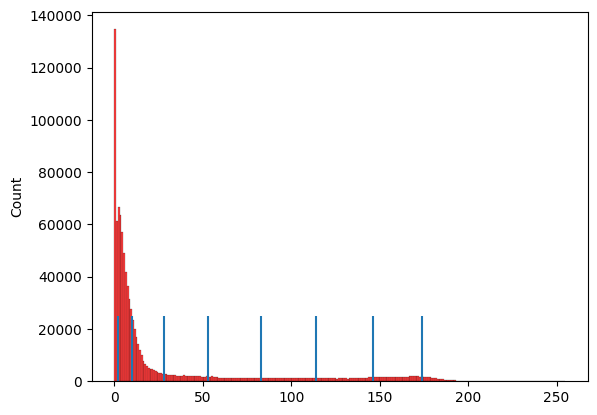

In [80]:
plt.figure()
sns.histplot(get_image(type_idx,idx)[:,:,2].flat, color="r", bins=256)
#sns.histplot(m.cluster_centers_.astype("int16"), color="b")
plt.vlines(m.cluster_centers_.astype("int16"), ymin=0, ymax=25000)

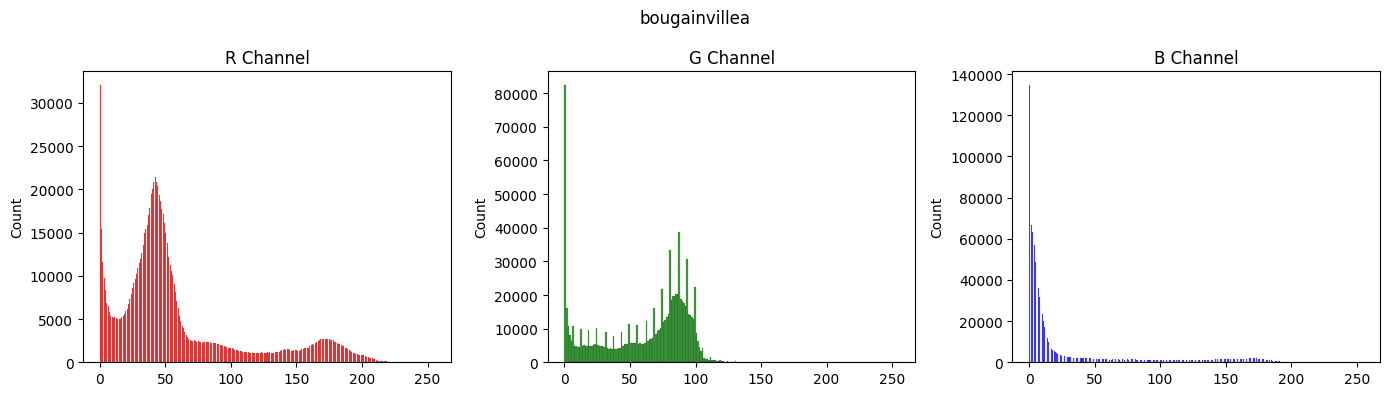

In [76]:
type_idx=0
idx=2
plot_hist_rgb(
    get_image(type_idx,idx), flower_types[type_idx]
)

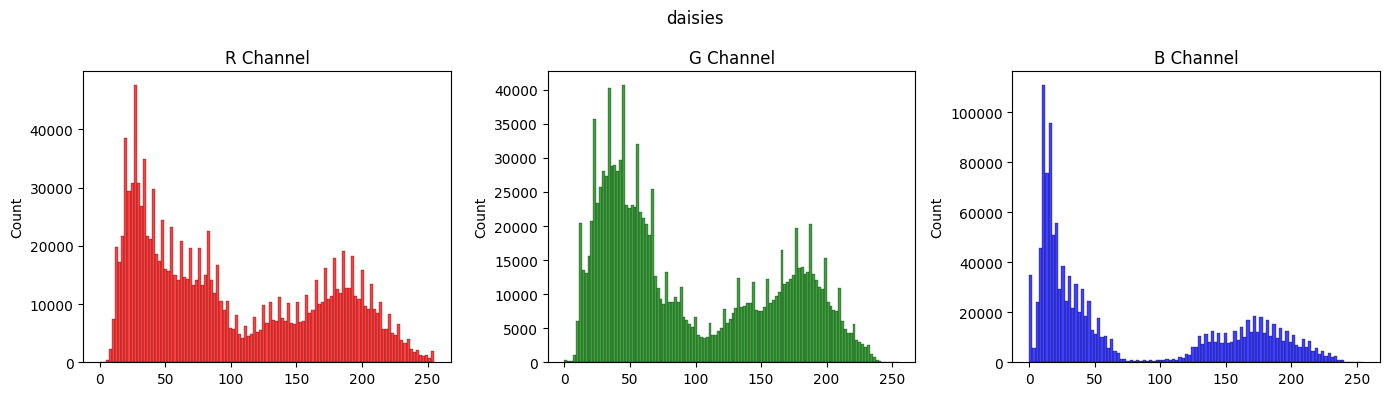

In [73]:
type_idx=1
idx=1
plot_hist_rgb(
    get_image(1,idx), flower_types[1]
)

### Using Separate RGB channels separate, as features

In [15]:
class Histogram_Model_RGB(Histogram_Model):
    def get_X_histograms(self, X):
        histogram_X = []
        for image in X:
            bins=np.empty(shape=(0))
            for dim in range(3):
                channel_bins = np.histogram(
                    image[:,:,dim], 
                    8, 
                    range=(0,255)
                )[0]
                channel_bins = self.scaler.fit_transform(
                    channel_bins.reshape(-1,1)
                ).ravel()
                bins = np.concatenate(
                    (bins, channel_bins)
                )
            histogram_X.append(bins)
        return histogram_X

In [16]:
X, y = get_all_data()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [49]:
m = Histogram_Model_RGB(predicter=KNN()).fit(X_train, y_train)

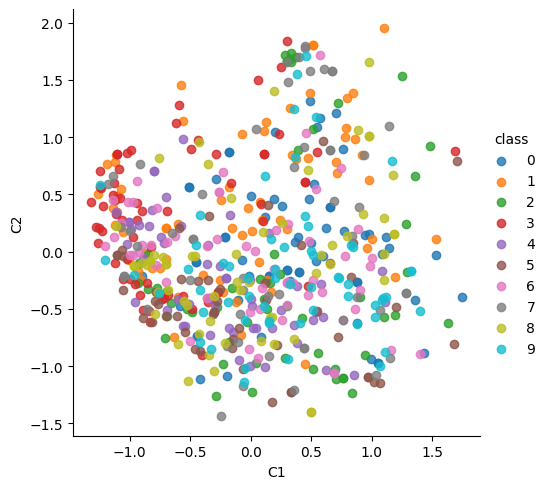

In [21]:
pca=PCA(n_components=2).fit(m.X)
pca_x=pca.transform(m.X)
temp_df=pd.DataFrame(data={"C1": pca_x[:,0], "C2": pca_x[:,1], "class":m.y})
sns.lmplot(temp_df, x="C1", y="C2", hue="class", fit_reg=False)

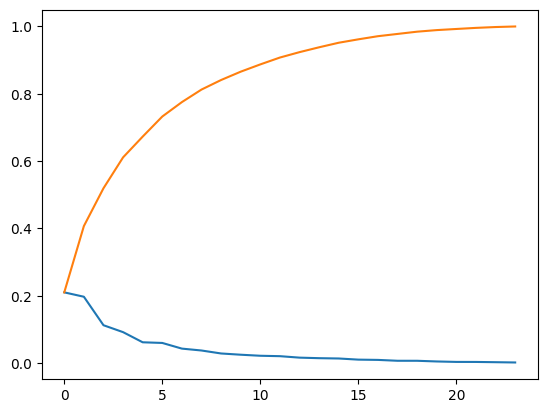

In [22]:
plt.plot(PCA().fit(m.X).explained_variance_ratio_)
plt.plot(PCA().fit(m.X).explained_variance_ratio_.cumsum())

The principle components seem to indicate that there are features that create a linear separation from the classes and that the features selected do not cluster the groups

In [50]:
preds = m.predict(X_train)

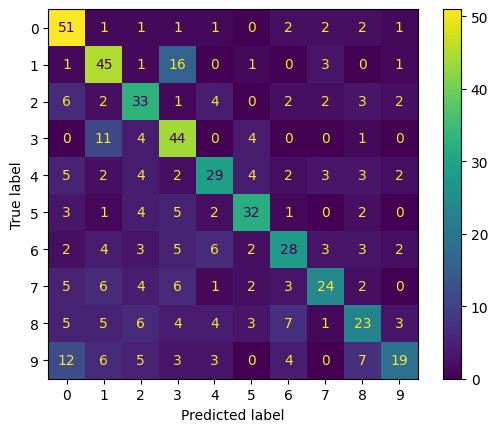

In [51]:
ConfusionMatrixDisplay(
    confusion_matrix(m.encoder.transform(y_train), preds)
).plot()

In [52]:
print(classification_report(m.encoder.transform(y_train), preds))

              precision    recall  f1-score   support

           0       0.57      0.82      0.67        62
           1       0.54      0.66      0.60        68
           2       0.51      0.60      0.55        55
           3       0.51      0.69      0.58        64
           4       0.58      0.52      0.55        56
           5       0.67      0.64      0.65        50
           6       0.57      0.48      0.52        58
           7       0.63      0.45      0.53        53
           8       0.50      0.38      0.43        61
           9       0.63      0.32      0.43        59

    accuracy                           0.56       586
   macro avg       0.57      0.56      0.55       586
weighted avg       0.57      0.56      0.55       586



In [53]:
matthews_corrcoef(m.encoder.transform(y_train), preds) 

0.5123050978293504

The results Are not Decent even in the training set

### Merging RGB channels into Single Channel

In [40]:
class Histogram_Model_Single_Channel(Histogram_Model):
    def get_X_histograms(self, X):
        histogram_X = []
        for image in X:
            bins = np.histogram(image.ravel(), 8, range=(0,255))[0]
            bins = self.scaler.fit_transform(bins.reshape(-1,1)).ravel()
            histogram_X.append(bins)
        return histogram_X

In [ ]:
X, y = get_all_data()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [41]:
m = Histogram_Model_Single_Channel().fit(X_train, y_train)

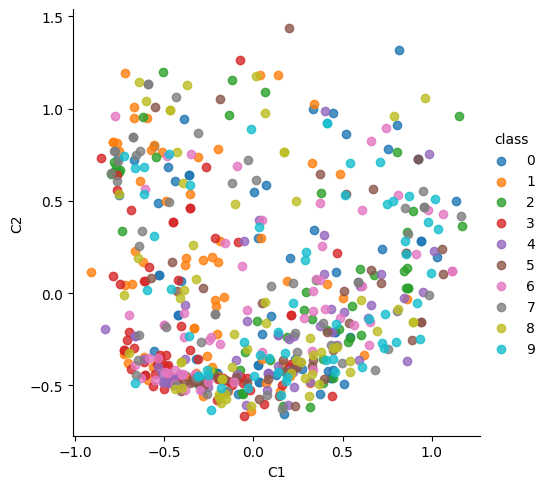

In [42]:
pca=PCA(n_components=2).fit(m.X)
pca_x=pca.transform(m.X)
temp_df=pd.DataFrame(data={"C1": pca_x[:,0], "C2": pca_x[:,1], "class":m.y})
sns.lmplot(temp_df, x="C1", y="C2", hue="class", fit_reg=False)

In [43]:
preds = m.predict(X_train)

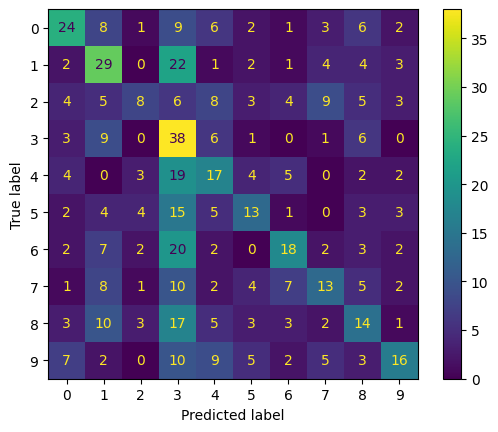

In [44]:
ConfusionMatrixDisplay(
    confusion_matrix(m.encoder.transform(y_train), preds)
).plot()

In [45]:
print(classification_report(m.encoder.transform(y_train), preds))

              precision    recall  f1-score   support

           0       0.46      0.39      0.42        62
           1       0.35      0.43      0.39        68
           2       0.36      0.15      0.21        55
           3       0.23      0.59      0.33        64
           4       0.28      0.30      0.29        56
           5       0.35      0.26      0.30        50
           6       0.43      0.31      0.36        58
           7       0.33      0.25      0.28        53
           8       0.27      0.23      0.25        61
           9       0.47      0.27      0.34        59

    accuracy                           0.32       586
   macro avg       0.35      0.32      0.32       586
weighted avg       0.35      0.32      0.32       586



In [46]:
matthews_corrcoef(m.encoder.transform(y_train), preds) 

0.2517242222836271

Single Channel Results were even worst

## Prediction using Histogram with Unsupervised Bin Selection

In [33]:
X,y=get_all_data(False)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)
del X,y

In [8]:
class Histogram_Model_Cluster_Bins():
    def __init__(
        self,
        n_clusters=8,
        predicter = SVC()
    ):
        self.clusters = [KMeans(n_clusters)]
        self.scaler = MinMaxScaler()
        self.encoder = LabelEncoder()
        self.predicter=predicter
    
    def get_X_histograms(self, X):
        pass
    
    def fit(self, X, y):
        histogram_X = self.get_X_histograms(X)
        self.encoder = self.encoder.fit(y)
        
        self.y = self.encoder.transform(y)
        self.X = np.array(histogram_X)
        self.predicter = self.predicter.fit(self.X, self.y)
        return self
    
    def predict(self, X):
        histogram_X = self.get_X_histograms(X)
        X = np.array(histogram_X)
        return self.predicter.predict(X)

### Using RGB channels

In [11]:
class Histogram_Model_Cluster_Bins_RGB(Histogram_Model_Cluster_Bins):    
    def __init__(self, n_clusters=8, predicter=SVC()):
        super().__init__(n_clusters, predicter)
        self.clusters = [KMeans(n_clusters) for i in range(3)]
        
    def get_X_histograms(self, X):
        for i, cluster in zip( range(3), self.clusters):
            channel = np.concatenate([ arr[:,:,i].ravel() for arr in X ])
            self.custers[i] = cluster.fit(channel.reshape(-1,1))
        
        histogram_X = []
        for image in X:
            bins=np.empty(shape=(0))
            for dim, cluster in zip(range(3), self.clusters):
                channel_bins = np.histogram(
                    image[:,:,dim], 
                    bins=cluster.cluster_centers_.astype("uint16").sort(), 
                    range=(0,255)
                )[0]
                channel_bins = self.scaler.fit_transform(
                    channel_bins.reshape(-1,1)
                ).ravel()
                bins = np.concatenate(
                    (bins, channel_bins)
                )
            histogram_X.append(bins)
        return histogram_X
    
    def fit(self, X, y):
        histogram_X = self.get_X_histograms(X)
        self.encoder = self.encoder.fit(y)
        
        self.y = self.encoder.transform(y)
        self.X = np.array(histogram_X)
        self.predicter = self.predicter.fit(self.X, self.y)
        return self
    
    def predict(self, X):
        histogram_X = self.get_X_histograms(X)
        X = np.array(histogram_X)
        return self.predicter.predict(X)

### Using Single Channel

In [ ]:
class Histogram_Model_Cluster_Bins_SingleChannel(Histogram_Model_Cluster_Bins):    
    def get_X_histograms(self, X):
        for file in X:
            
        channel = np.concatenate([ arr[:,:,i].ravel() for arr in X ])
        self.custers[0] = cluster.fit(channel.reshape(-1,1))
        
        histogram_X = []
        for image in X:
            bins = np.histogram(
                image[:,:,dim], 
                bins=cluster.cluster_centers_.astype("uint16").sort(), 
                range=(0,255)
            )[0]
            
            bins = self.scaler.fit_transform(
                bins.reshape(-1,1)
            ).ravel()
            
            histogram_X.append(bins)
        return histogram_X
    
    def fit(self, X, y):
        histogram_X = self.get_X_histograms(X)
        self.encoder = self.encoder.fit(y)
        
        self.y = self.encoder.transform(y)
        self.X = np.array(histogram_X)
        self.predicter = self.predicter.fit(self.X, self.y)
        return self
    
    def predict(self, X):
        histogram_X = self.get_X_histograms(X)
        X = np.array(histogram_X)
        return self.predicter.predict(X)

In [42]:
temp = np.concatenate( [ read_image(file).mean(axis=2).ravel() for file in X_train ] ).reshape(-1,1)

In [43]:
c = MiniBatchKMeans().fit(temp)

MemoryError: Unable to allocate 9.68 GiB for an array with shape (1299226720,) and data type float64

## Color Correlogram

In [19]:
import ray

ray.init()


2023-02-25 15:29:19,998	INFO worker.py:1538 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.9.7', ray_version='2.2.0', ray_commit='b6af0887ee5f2e460202133791ad941a41f15beb', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:60974', 'raylet_socket_name': 'tcp://127.0.0.1:58764', 'webui_url': '', 'session_dir': 'C:\\Users\\joelp\\AppData\\Local\\Temp\\ray\\session_2023-02-25_15-29-15_246655_6132', 'metrics_export_port': 61778, 'gcs_address': '127.0.0.1:56980', 'address': '127.0.0.1:56980', 'dashboard_agent_listen_port': 52365, 'node_id': 'dfe9aae79bd6e17200be4f49612a108609c806169adc5efb499ea1e1'})

In [24]:
@ray.remote
def get_all_histogram():
    counts = dict(zip(range(256), [0] * 256))
    for file in os.listdir(PATH):
        temp = read_image(file)
        for value in temp.ravel():
            counts[value]+=1
    return counts

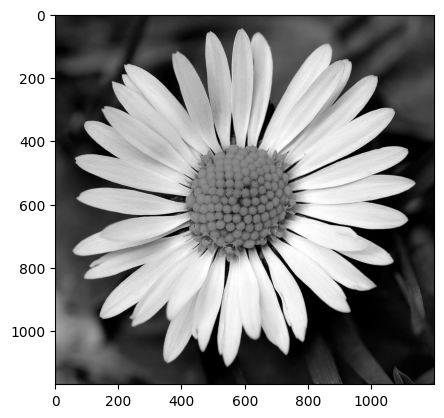

In [36]:
plt.imshow(get_image(1).mean(axis=2), cmap="gray")

In [40]:
get_image(1).mean(axis=2).astype("uint16")

array([[ 44,  44,  44, ...,  41,  39,  36],
       [ 44,  44,  44, ...,  42,  39,  37],
       [ 44,  44,  44, ...,  42,  40,  38],
       ...,
       [102, 101, 100, ...,  33,  26,  19],
       [102, 101, 100, ...,  30,  18,   8],
       [101, 102, 103, ...,  15,   9,   8]], dtype=uint16)

# Texture

In [18]:
from skimage.feature import graycomatrix
from pyfeats.textural import glcm_features
from random import shuffle

## Gray Level Co-ocurrence Matrix

In [7]:
get_image(1).mean(axis=2).astype("uint16")

array([[ 44,  44,  44, ...,  41,  39,  36],
       [ 44,  44,  44, ...,  42,  39,  37],
       [ 44,  44,  44, ...,  42,  40,  38],
       ...,
       [102, 101, 100, ...,  33,  26,  19],
       [102, 101, 100, ...,  30,  18,   8],
       [101, 102, 103, ...,  15,   9,   8]], dtype=uint16)

In [10]:
def glcm(img, n_values, quantization=1):
    M = np.zeros(shape=(n_values, n_values))
    
    w = int(img.shape[1]/quantization)
    h = int(img.shape[0]/quantization)
    
    img = cv2.resize(img, (w,h))
    
    for i in range(img.shape[0]):
        for j in range(img.shape[0]-1):
            M[ img[i,j], img[i,j+1] ] += 1
    return M/M.sum()

In [12]:
def get_angular_moment(glcm):
    return (glcm**2).sum()

def get_contrast(glcm):
    n = glcm.shape[0]
    contrast = np.abs(
        np.array( 
            [[i for j in range(n)] for i in range(n)]
        ) - np.array( 
            [ list(range(n)) for i in range(n) ]
        ),
        dtype=float
    )**2
    contrast*=glcm
    return contrast.sum()

def get_correlation(glcm):
    #TODO fix this function
    mean_x, mean_y = glcm.mean(axis=0), glcm.mean(axis=1)
    std_x, std_y = glcm.std(axis=0), glcm.std(axis=1)

    i_pos = np.array( [[i for j in range(n)] for i in range(n)] )
    j_pos = np.array( [ list(range(n)) for i in range(n) ] )
    
    return ( ( (i_pos - mean_x)*(j_pos - mean_y)*glcm) / (std_x * std_y) ).sum()

def get_ssv(glcm):
    u = glcm.mean()
    n = glcm.shape[0]
    i = np.array( [[i for j in range(n)] for i in range(n)] )
    
    return ((i - u)**2 * glcm).sum()

def get_inverse_dif_moment(glcm):
    n = glcm.shape[0]
    i_pos = np.array( [[i for j in range(n)] for i in range(n)] )
    j_pos = np.array( [ list(range(n)) for i in range(n) ] )
    
    temp = 1 / (1 + (i_pos - j_pos)**2)
    return (glcm * temp).sum()

In [22]:
get_angular_moment(glcm(
    get_image(1).mean(axis=2).astype("uint16"),
    256,
    1
))

0.0015539735205932804

In [19]:
dict(
    zip(
        glcm_features(get_image(1).mean(axis=2).astype("uint16"))[2],
        glcm_features(get_image(1).mean(axis=2).astype("uint16"))[0],
    )
)

{'GLCM_ASM_Mean': 0.0006677368397308315,
 'GLCM_Contrast_Mean': 180.1202581309808,
 'GLCM_Correlation_Mean': 0.9877178507936774,
 'GLCM_SumOfSquaresVariance_Mean': 7333.323627460432,
 'GLCM_InverseDifferenceMoment_Mean': 0.40300958819506993,
 'GLCM_SumAverage_Mean': 250.17316305997528,
 'GLCM_SumVariance_Mean': 29153.174251710738,
 'GLCM_SumEntropy_Mean': 8.726537583293533,
 'GLCM_Entropy_Mean': 11.699856853926114,
 'GLCM_DifferenceVariance_Mean': 0.0006285976217217841,
 'GLCM_DifferenceEntropy_Mean': 3.3472211537421774,
 'GLCM_Information1_Mean': -0.4875542446994366,
 'GLCM_Information2_Mean': 0.9997144942600898,
 'GLCM_MaximalCorrelationCoefficient_Mean': 4.013193256372533}

In [71]:
feat_labels = glcm_features(get_image(1).mean(axis=2).astype("uint16"))[2]

In [26]:
train_files, test_files = train_test_split(os.listdir("flowers/"), test_size=0.2, random_state=2)

In [ ]:
ray.init()

In [65]:
@ray.remote
def get_image_texture_and_class(i, file):
    if (i%20==0): print(i)
    x = glcm_features(
        read_image(file)
    )[0].reshape(-1,1).T

    return x

def get_images_texture_and_classes(files):
    X = np.empty(shape=(0, 14))
    
    res = []
    for i, file in enumerate(files):
        res.append( get_image_texture_and_class.remote(i, file) ) 
    xys = ray.get(res)
    
    print("Concluded processing the data.\nAppending...")
    
    for x_values, y_values in xys:
        X = np.concatenate((X, x_values), axis=0)

    return X

In [66]:
X_train = get_images_texture_and_classes(train_files)

(get_image_texture_and_class pid=15916) 0
(get_image_texture_and_class pid=15916) 20
(get_image_texture_and_class pid=15116) 40
(get_image_texture_and_class pid=19572) 60
(get_image_texture_and_class pid=19572) 80
(get_image_texture_and_class pid=15116) 100
(get_image_texture_and_class pid=1064) 120
(get_image_texture_and_class pid=15916) 140
(get_image_texture_and_class pid=15916) 160
(get_image_texture_and_class pid=15116) 180
(get_image_texture_and_class pid=1064) 200
(get_image_texture_and_class pid=19572) 220
(get_image_texture_and_class pid=19572) 240
(get_image_texture_and_class pid=1064) 260
(get_image_texture_and_class pid=19572) 280
(get_image_texture_and_class pid=15916) 300
(get_image_texture_and_class pid=15116) 320
(get_image_texture_and_class pid=15916) 340
(get_image_texture_and_class pid=1064) 360
(get_image_texture_and_class pid=1064) 380
(get_image_texture_and_class pid=15116) 400
(get_image_texture_and_class pid=1064) 420
(get_image_texture_and_class pid=1064) 440
(

In [ ]:
y_train = list(map(lambda x: "_".join(x.split("_")[:-1]), train_files))

In [67]:
from sklearn.decomposition import PCA

In [102]:
enc = LabelEncoder().fit(y_train)

GLCM_ASM_Mean  GLCM_Contrast_Mean  GLCM_Correlation_Mean  \
0         0.000142         2023.068484               0.819081   
1         0.000178         2916.720369               0.521556   
2         0.000136         2387.321192               0.633182   
3         0.000399         1923.614857               0.842734   
4         0.000189         1961.467267               0.688890   
..             ...                 ...                    ...   
581       0.017242         1391.747718               0.858401   
582       0.000114         2095.853508               0.712971   
583       0.000277         2512.962547               0.757898   
584       0.000357         5667.491686               0.345910   
585       0.000172         2701.715653               0.688366   

     GLCM_SumOfSquaresVariance_Mean  GLCM_InverseDifferenceMoment_Mean  \
0                       5677.638604                           0.098426   
1                       2992.501884                           0.122971   
2                       3345.028737                           0.082936   
3                       6112.779642                           0.149089   
4                       3282.483274                           0.130230   
..                              ...                                ...   
581                     5059.442394                           0.417346   
582                     3600.018028                           0.092354   
583                     5258.555621                           0.116077   
584                     4459.544217                           0.193608   
585                     4374.231800                           0.087439   

     GLCM_SumAverage_Mean  GLCM_SumVariance_Mean  GLCM_SumEntropy_Mean  \
0              215.923126           20687.485931              8.863932   
1              227.013021            9053.287167              8.483809   
2              190.875931           10992.793757              8.466529   
3              234.817566           22527.503710              8.691111   
4              245.279830           11168.465828              8.682561   
..                    ...                    ...                   ...   
581            108.151527           18846.021857              6.851180   
582            187.073678           12304.218603              8.678151   
583            224.217610           18521.259936              8.872491   
584            183.865112           12170.685182              8.509479   
585            176.568533           14795.211546              8.663092   

     GLCM_Entropy_Mean  GLCM_DifferenceVariance_Mean  \
0            14.402077                      0.000120   
1            13.916297                      0.000196   
2            13.919063                      0.000121   
3            13.709450                      0.000154   
4            13.909711                      0.000200   
..                 ...                           ...   
581          10.048801                      0.000640   
582          14.479046                      0.000091   
583          14.432266                      0.000129   
584          13.307376                      0.000295   
585          14.220668                      0.000089   

     GLCM_DifferenceEntropy_Mean  GLCM_Information1_Mean  \
0                       5.957606               -0.176447   
1                       5.818385               -0.198891   
2                       5.983907               -0.162476   
3                       5.717825               -0.220458   
4                       5.603193               -0.213298   
..                           ...                     ...   
581                     4.301291               -0.341106   
582                     6.131100               -0.131190   
583                     5.984294               -0.174915   
584                     5.455708               -0.251723   
585                     6.072387               -0.159263   

     GLCM_Information2_Mean  GLCM_MaximalCorrelation

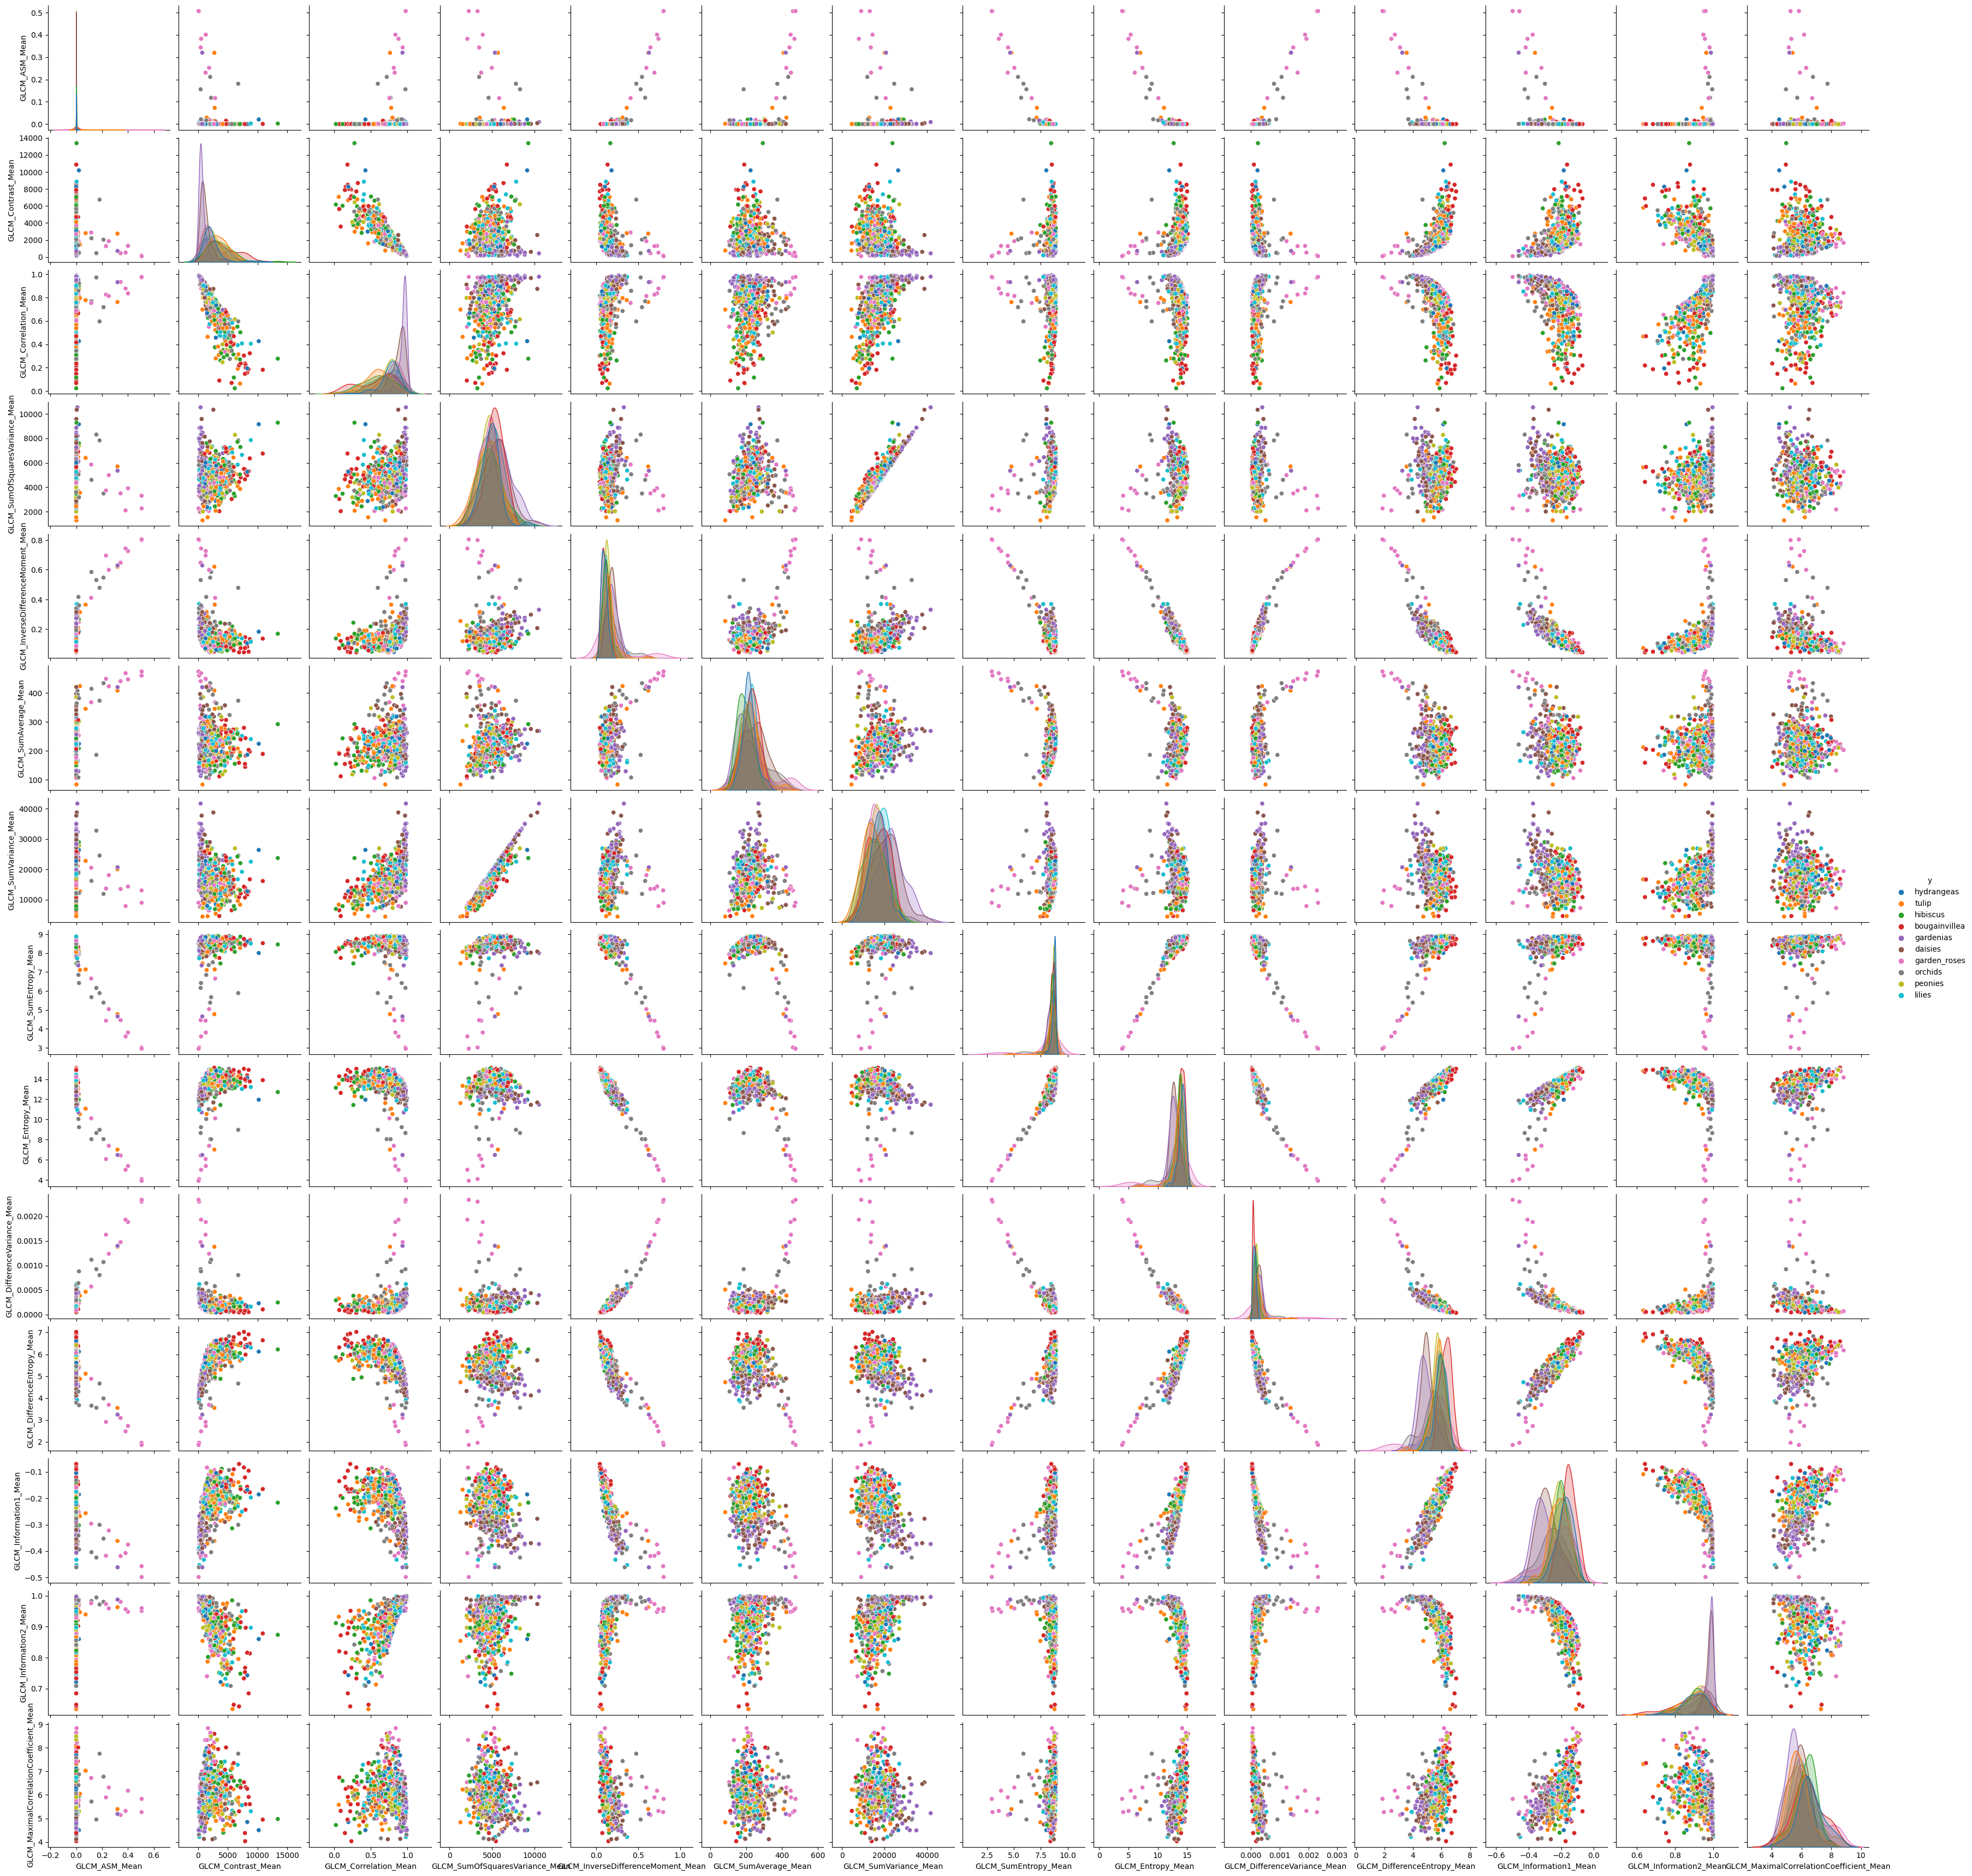

In [99]:
sns.pairplot(
    pd.concat((pd.DataFrame(X_train, columns=feat_labels), pd.DataFrame(y_train, columns=["y"])), axis=1),
    hue="y")

In [100]:
reduced_x = PCA(n_components=2).fit_transform(X_train)

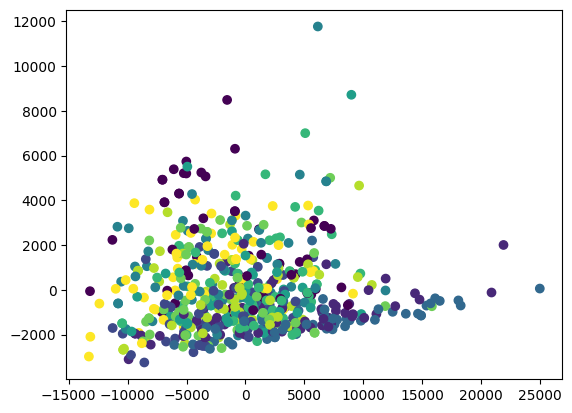

In [103]:
plt.scatter(reduced_x[:,0], reduced_x[:,1], c=enc.transform(y_train))

In [104]:
ray.shutdown()

## Law's Texture Mask